<a href="https://colab.research.google.com/github/Haodong12/AIPI-590/blob/main/assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment #06

This assignment performed an analysis of PDP, ICE, and ALE plots and correlation base on california housing dataset.

Haodong He




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [29]:
! pip install alibi --quiet

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from alibi.explainers import ALE

In [13]:
# Load the California housing dataset
data = fetch_california_housing()
X = data.data
y = data.target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Exploratory Data Analysis (EDA) – Feature Correlation
# Create a DataFrame for features
df = pd.DataFrame(X, columns=data.feature_names)

# Display the first few rows of the DataFrame
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


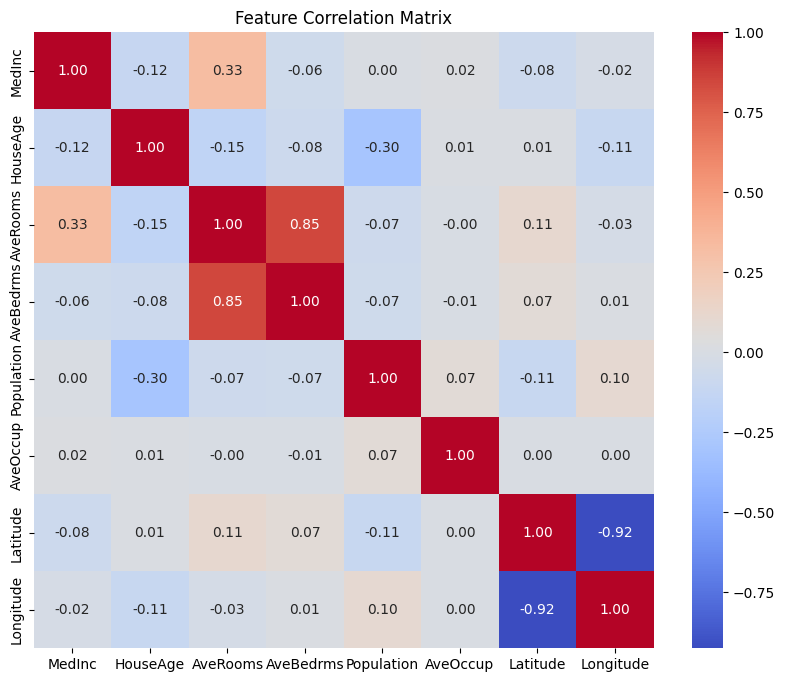

In [15]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

Summary of Correlation Effects and Impact on Results:
Latitude and MedInc:
Despite dropping Longitude, Latitude and MedInc remain somewhat correlated, as wealthier areas tend to be in lower latitude regions (closer to the coast). This correlation could exaggerate the effect of each feature in the PDP plots, but the ALE plots provide a more accurate, localized interpretation by adjusting for these correlations.
HouseAge and MedInc:
There is likely some correlation between HouseAge and MedInc, with newer homes typically being located in wealthier areas. The PDP for HouseAge might not fully separate the effect of income from house age. However, the ALE plot adjusts for this, showing that the price drop is sharper for newer homes, with a slower decline for older homes.
AveOccup:
Since AveOccup is not correlated with other features, both the PDP and ALE plots consistently show that it has a negligible effect on house prices. Its minimal impact remains clear in both global and local perspectives.

In [20]:
# Re-create the correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop highly correlated features
df_reduced = df.drop(columns=to_drop)

# Show remaining features after dropping
print("Dropped features:", to_drop)
print("Remaining features:", df_reduced.columns)

Dropped features: ['AveBedrms', 'Longitude']
Remaining features: Index(['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude'], dtype='object')


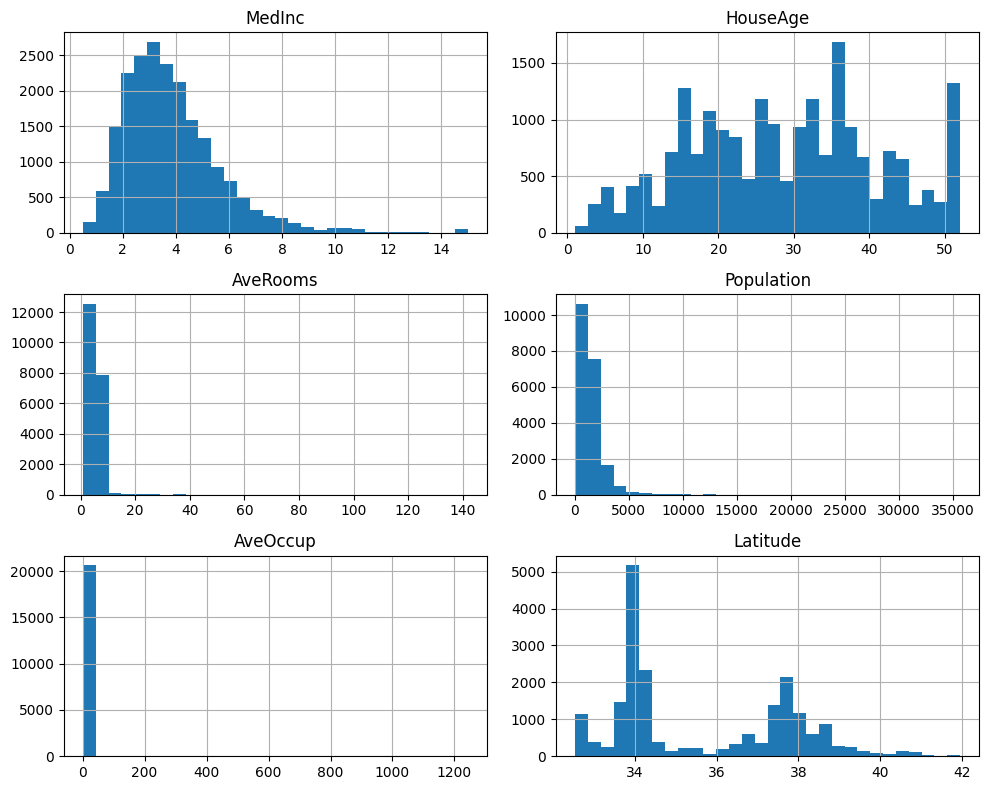

In [21]:
# Plot histograms of the remaining features
df_reduced.hist(figsize=(10, 8), bins=30)
plt.tight_layout()
plt.show()

In [24]:
# Get feature importance from the Random Forest model
importances = model.feature_importances_

# Sort feature importances in descending order and print them
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {data.feature_names[indices[f]]} ({importances[indices[f]]:.4f})")


Feature ranking:
1. feature MedInc (0.5249)
2. feature AveOccup (0.1384)
3. feature Latitude (0.0889)
4. feature Longitude (0.0886)
5. feature HouseAge (0.0546)
6. feature AveRooms (0.0443)
7. feature Population (0.0306)
8. feature AveBedrms (0.0296)


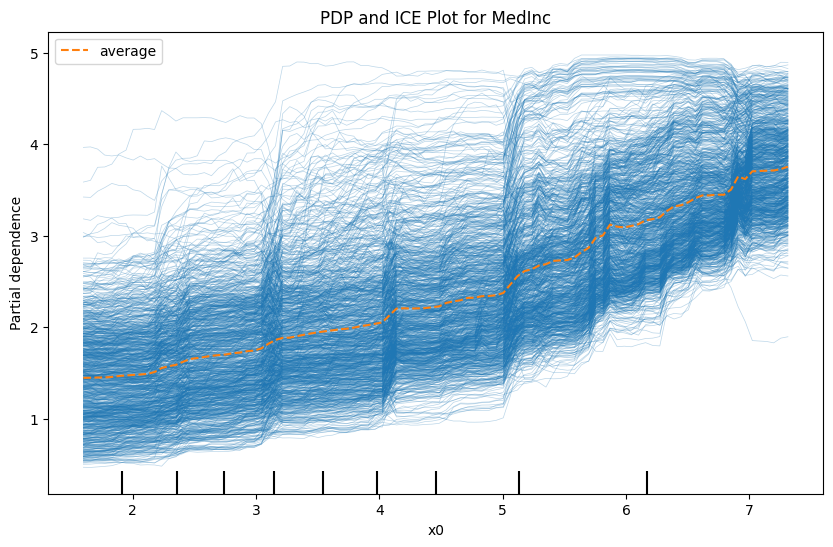

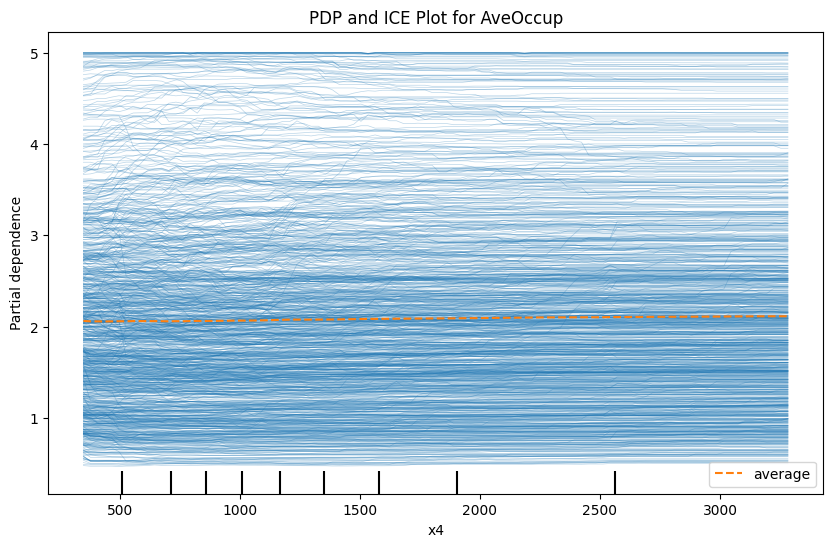

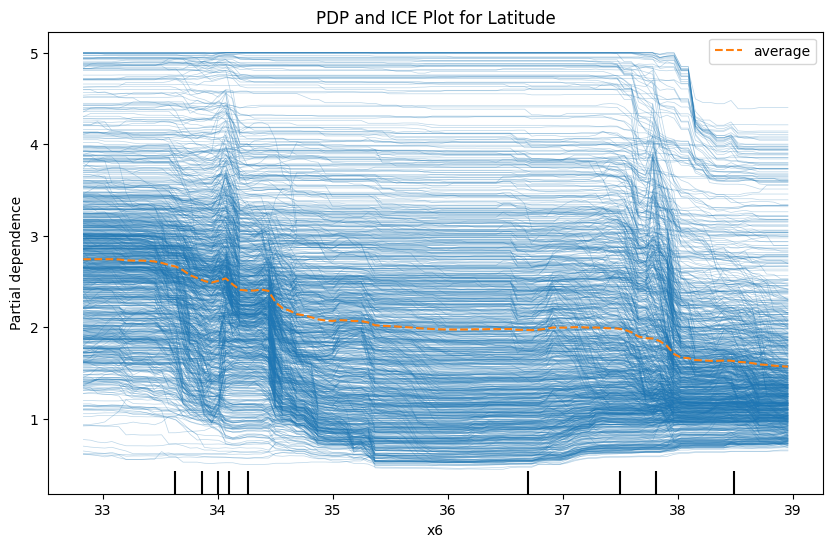

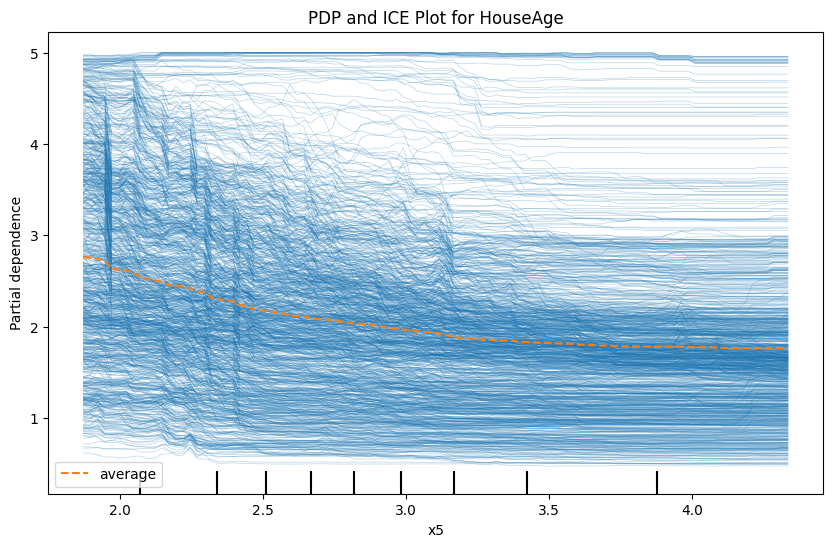

In [44]:
# Feature names as per your dataset and feature importance
feature_names = ['MedInc', 'AveOccup', 'Latitude', 'HouseAge']

# Select the top 4 important features based on feature importance
features = [0, 4, 6, 5]  # These are indices for the features

# Create a plot for each feature individually
for i, feature in enumerate(features):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Generate PDP and ICE plot for each feature
    PartialDependenceDisplay.from_estimator(model, X_train, [feature], kind='both', ax=ax)

    # Set the x-axis label to the appropriate feature name
    ax.set_xlabel(feature_names[i])

    # Set the title
    plt.title(f'PDP and ICE Plot for {feature_names[i]}')

    # Reduce the number of x-ticks for better readability
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Limit the number of x-ticks to 5

    # Show the plot
    plt.show()


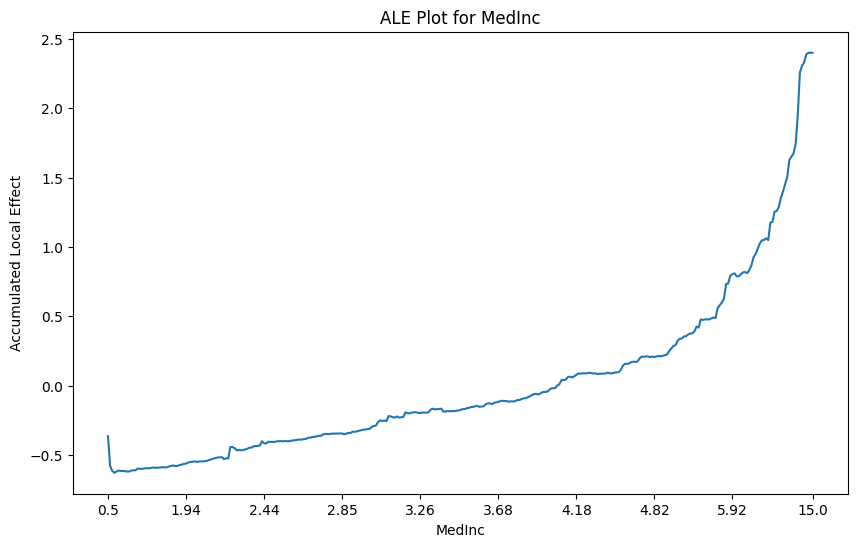

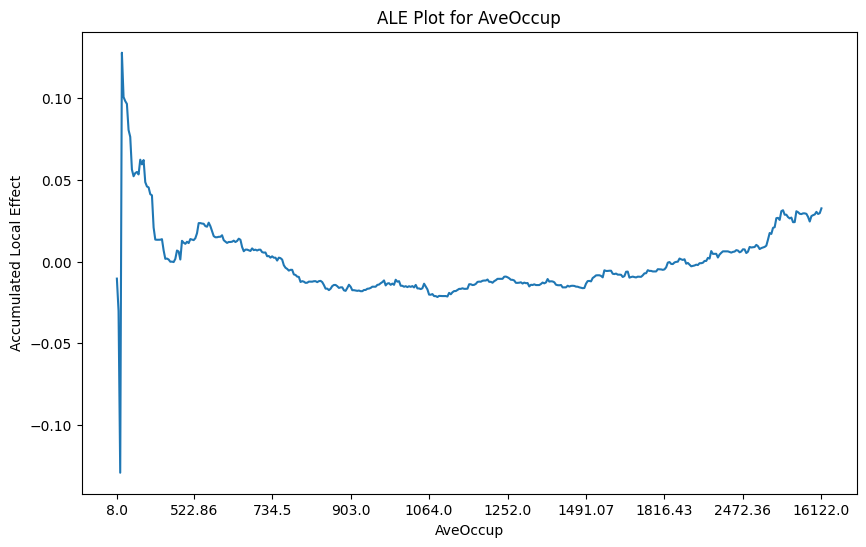

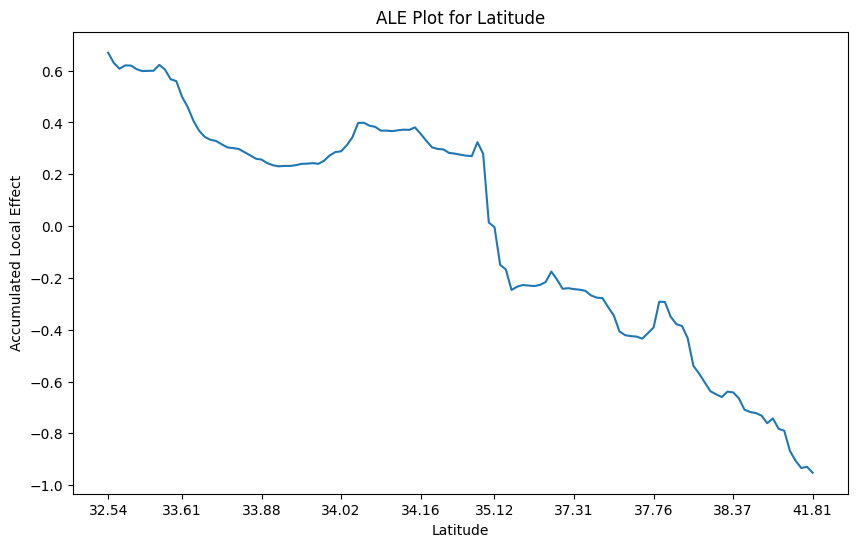

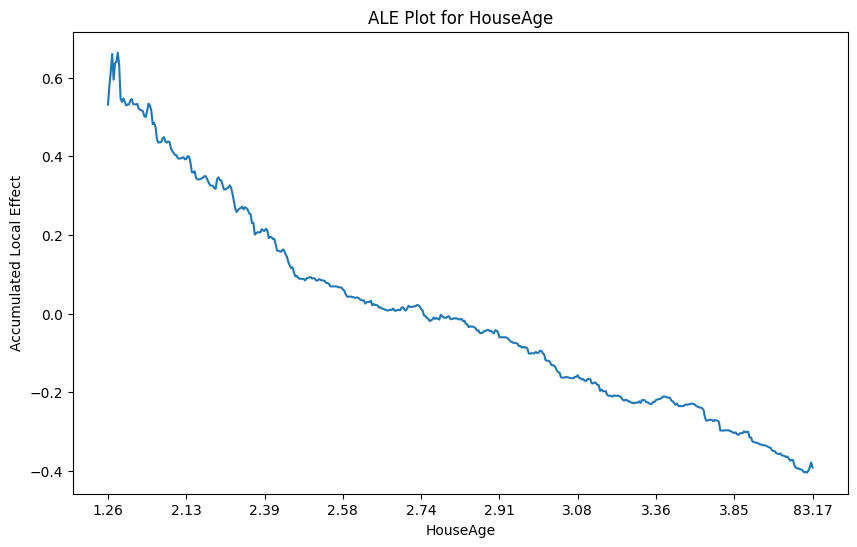

In [45]:
# Define the model prediction function
predict_fn = model.predict

# Create an ALE explainer for the model
ale_explainer = ALE(predict_fn, feature_names=data.feature_names)

# Fit the ALE explainer on the test data
ale_exp = ale_explainer.explain(X_test)

# Feature names for labeling the plots
feature_names = ['MedInc', 'AveOccup', 'Latitude', 'HouseAge']

# Indices of the top features
features = [0, 4, 6, 5]

# Generate ALE plots for each feature
for i, feature in enumerate(features):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot ALE for the selected feature
    # Get ALE values for the current feature
    feature_idx = feature  # Index of the feature

    # Plot the ALE for the current feature
    plt.plot(ale_exp.ale_values[feature_idx], label=feature_names[i])

    # Set the x-axis to the feature values
    # Select fewer x-ticks to make them readable
    xtick_pos = np.linspace(0, len(ale_exp.feature_values[feature_idx]) - 1, 10).astype(int)
    plt.xticks(ticks=xtick_pos, labels=np.round(ale_exp.feature_values[feature_idx][xtick_pos], 2))

    # Add title and labels
    plt.title(f'ALE Plot for {feature_names[i]}')
    plt.xlabel(feature_names[i])
    plt.ylabel('Accumulated Local Effect')

    # Show the plot
    plt.show()


**PDP and ICE Plots:**
1. MedInc (Median Income) PDP and ICE Plot:
PDP Analysis: The orange dashed line shows a clear positive trend. As Median Income increases, house prices also rise, which is expected. The increase is not completely linear, but overall, the trend is upward.
ICE Analysis: The ICE lines exhibit some variation, especially for lower income levels, but most individual predictions follow a similar upward trend as median income increases. There are some individual instances that deviate more at the higher income range, which indicates that while the general trend holds, some houses are influenced more or less by income.
2. AveOccup (Average Occupancy) PDP and ICE Plot:
PDP Analysis: The PDP line is relatively flat, suggesting that Average Occupancy doesn't significantly influence house prices on average.
ICE Analysis: The individual lines are also relatively flat, confirming that this feature has minimal impact on predictions across the dataset. There's very little variability in how the model responds to changes in occupancy levels.
3. Latitude PDP and ICE Plot:
PDP Analysis: The plot shows a general downward trend, meaning that house prices decrease as you move north (increase in latitude). This is likely due to the fact that higher latitudes in California correspond to less expensive regions.
ICE Analysis: There’s a noticeable amount of individual variability, particularly at certain latitude ranges, where some predictions drop more steeply than others. This suggests geographical clusters where house prices drop significantly based on the location.
4. HouseAge PDP and ICE Plot:
PDP Analysis: Plot shows a general negative correlation between HouseAge and house prices. As the age of houses increases, house prices tend to decrease gradually. This is expected, as older houses generally sell for less compared to newer ones.
ICE Analysis: The ICE lines show a consistent downward trend. This suggests that for most houses in the dataset, their age negatively impacts their price. However, there is noticeable variation at the lower end of the scale (around HouseAge = 2), where some individual lines show steeper drops while others level off. This could indicate that certain houses are less affected by age due to other factors.

**ALE Plots:**
1. MedInc (Median Income) ALE Plot:
ALE Analysis: The ALE plot shows that house prices increase significantly for higher income levels. Interestingly, the curve is more gradual at the start but becomes steeper after a certain threshold, indicating that at higher income levels, the impact of income on house prices becomes stronger.
2. AveOccup (Average Occupancy) ALE Plot:
ALE Analysis: Similar to the PDP and ICE plots, the ALE plot for AveOccup shows little influence on house prices. There is a minor downward effect at very low occupancy levels, but for the most part, the feature's impact is minimal.
3. Latitude ALE Plot:
ALE Analysis: The ALE plot for Latitude shows a clear downward trend, with house prices decreasing steadily as latitude increases. The effect is more pronounced between certain latitude ranges, which aligns with the geographic variation in housing costs across northern and southern California.
4. Longitude ALE Plot:
ALE Analysis: The ALE plot confirms the negative relationship between HouseAge and house prices. The effect is strongest when houses are relatively new (lower age values), with a significant drop in house prices for homes aged between 1 and 3 (normalized age range). After this initial decline, the effect continues but becomes more gradual, suggesting that older homes (above 3 in the normalized scale) experience diminishing negative effects of age. At a certain point, the decline levels off slightly.

**Differences Between PDP and ALE Plots:**

MedInc: Both PDP and ALE show an upward trend, but the ALE plot highlights how the effect of income becomes stronger at higher levels, providing a more detailed local perspective.


AveOccup: Both plots show minimal impact on house prices, but the ALE plot provides more localized fluctuations that aren’t captured in the PDP.

Latitude: Both plots agree that higher latitudes (northern regions) have lower house prices, but ALE provides a more refined view of where price drops are steeper, indicating geographic boundaries.

HouseAge: The PDP shows a steady decline in prices as house age increases, while the ALE plot reveals that this effect is much stronger for newer homes, with price drops leveling out for older houses.

In cases where correlations exist (like between MedInc and Latitude or HouseAge), ALE plots are more reliable than PDPs because they show the localized impact of each feature, adjusted for interactions with other features.


**Interesting Findings Across the Four Features:**

MedInc: Higher incomes result in dramatically higher house prices, especially in wealthier areas, which is reflected more clearly in the ALE plot.

Latitude: Geographic location, as captured by latitude, has a strong influence on house prices, particularly in southern California, where price clusters lead to steep drops at certain latitudes.

HouseAge: While older houses are generally cheaper, the ALE plot suggests that newer houses experience the sharpest price depreciation, with older houses stabilizing somewhat as they age.

AveOccup: The occupancy level has minimal impact on house prices, with both the PDP and ALE confirming its lack of importance.
